# Emotion-Recognition Kaggle Model V9

## Transfer Learning

This time I will try to use VGG16 as base model, on v8 I only removed the last layer, now I will try to remove more layers.

In [1]:
# Imports
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import random
import glob
import itertools
import os
import shutil
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import warnings
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# Classses Distribution
print("Dataset Classes Distribution")

# Path to dataset
dataset_path = '../datasets/kaggle_dataset_train/'

# Let's display and count the files in the Kaggle training dataset
sd.seedir(dataset_path, style='emoji', itemlimit=10, depthlimit=1, beyond='content')

# Find number of images for each class
classes = []
values = []
for emotion in os.listdir(dataset_path):
    classes.append(emotion)
    values.append(len(os.listdir(dataset_path+emotion)))

# Chart visualization of the classes
fig = pgo.Figure(data=[pgo.Pie(labels=classes, values=values, hole=.4)])
fig.show()

Dataset Classes Distribution
📁 /
├─📁 angry/
│ └─0 folder(s), 3595 file(s)
├─📁 disgust/
│ └─0 folder(s), 393 file(s)
├─📁 fear/
│ └─0 folder(s), 3688 file(s)
├─📁 happy/
│ └─0 folder(s), 6493 file(s)
├─📁 neutral/
│ └─0 folder(s), 4469 file(s)
├─📁 sad/
│ └─0 folder(s), 4347 file(s)
└─📁 surprise/
  └─0 folder(s), 2854 file(s)


In [3]:
# I create a different folder for the validation set
os.chdir('../datasets/')
if os.path.isdir('kaggle_dataset_validate/') is False:
    os.makedirs('kaggle_dataset_validate/angry')
    os.makedirs('kaggle_dataset_validate/disgust')
    os.makedirs('kaggle_dataset_validate/fear')
    os.makedirs('kaggle_dataset_validate/happy')
    os.makedirs('kaggle_dataset_validate/neutral')
    os.makedirs('kaggle_dataset_validate/sad')
    os.makedirs('kaggle_dataset_validate/surprise')

    # Now I move 10% of random images from each train class to the proper validation set
    for i in random.sample(glob.glob('kaggle_dataset_train/angry/*'), 399):
        shutil.move(i, 'kaggle_dataset_validate/angry')        
    for i in random.sample(glob.glob('kaggle_dataset_train/disgust/*'), 43):
        shutil.move(i, 'kaggle_dataset_validate/disgust')
    for i in random.sample(glob.glob('kaggle_dataset_train/fear/*'), 409):
        shutil.move(i, 'kaggle_dataset_validate/fear')
    for i in random.sample(glob.glob('kaggle_dataset_train/happy/*'), 721):
        shutil.move(i, 'kaggle_dataset_validate/happy')
    for i in random.sample(glob.glob('kaggle_dataset_train/neutral/*'), 496):
        shutil.move(i, 'kaggle_dataset_validate/neutral')
    for i in random.sample(glob.glob('kaggle_dataset_train/sad/*'), 483):
        shutil.move(i, 'kaggle_dataset_validate/sad')
    for i in random.sample(glob.glob('kaggle_dataset_train/surprise/*'), 317):
        shutil.move(i, 'kaggle_dataset_validate/surprise')


os.chdir('../notebooks')

In [4]:
# Process the data
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define sets
# Since the tesing set has more data than the created validate, we will use test as validate and validate as test
training_path = '../datasets/kaggle_dataset_train/'
valididation_path = '../datasets/kaggle_dataset_test/'
testing_path = '../datasets/kaggle_dataset_validate/'

Num GPUs Available:  1


Now we have to preprocess the images for VGG16. Not only that, our images have only 1 channel (grayscale) but the VGG16 model requires 3 channel (RBG). The VGG16 paper states:

“The only pre-processing we do is subtracting the mean RGB value,
computed on the training set, from each pixel.”

VGG16 was trained on the ImageNet images, so the mean RGB values are calculated based on the ImageNet dataset.

To compute the mean on single color channel, for example red, we compute the average red value of all the pixels across every ImageNet image. The same procedure applies for the other two color channels, green and blue. Then in order to preprocess every image, we subtract the mean red value from the original red value in each pixel. Again the same applies for blue and green.

In [5]:
# The images I have in the Kaggle dataset are in grayscale, for VGG16 I have to convert them to RGB with three channels, what we do is just exand the channel we already have to 3 channels

def vgg16_processed(img):
    # I first "convert" the image to RGB, by repeating the grayscale data x3 along the channel axis
    x=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    mychannel=np.repeat(x[:, :, np.newaxis], 3, axis=2)
    # Then I use the tf VGG16 preocessing which basically subtracts the mean BGR value from each pixel
    processedimage = tf.keras.applications.vgg16.preprocess_input(mychannel)
    return processedimage

# I create the same function again but it won't return nothing, it will inded diplay the processed image
def vgg16_processed_tf(img):
   x=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
   mychannel=np.repeat(x[:, :, np.newaxis], 3, axis=2)
   print("This is the grayscale image after it was converted to color",mychannel)
   processedimage = tf.keras.applications.vgg16.preprocess_input(mychannel)
   print("This is the color image after vgg16 preprocess",processedimage)
   plt.imshow(processedimage)
   plt.show()

# Here's an example with a grayscale image
# gray = cv2.imread("../datasets/kaggle_dataset_train/angry/Training_3908.jpg")
# vgg16_processed_tf(gray)

As we can see from the result above, the VGG16 preprocessing was correctly done, for example:
`[162.9837 162.9837 162.9837] - [ 59.0447  46.2047  39.3037]` = `[103.939 116.779 123.68]`
Which is the mean blue, green, and red values from ImageNet. VGG16 uses the Caffe library, which uses a BGR color scheme for reading images, that's why the results are in BGR and not the inital RGB.

```python
meanImageNetBGR = {
    blue: 103.939,
    green: 116.779,
    red: 123.68
};
```


In [6]:
# Now we use Keras's ImageDataGenerator class to create batches of data from the training, validation and testing sets
"""
for the preocessing_function I pass the function I created myself above, since we cannot use the normal tf function provided for vgg16 since we had first to expand the grayscale channel
I also remove color_mode since it was set to grayscale, and change target size to 224,224 since it was the original input shape of the VGG16 model
"""
train_batches = ImageDataGenerator(preprocessing_function=vgg16_processed).flow_from_directory(directory=training_path, target_size=(224,224), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=vgg16_processed).flow_from_directory(directory=valididation_path, target_size=(224,224), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=vgg16_processed).flow_from_directory(directory=testing_path, target_size=(224,224), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=32, shuffle=False)

Found 25839 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 2867 images belonging to 7 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

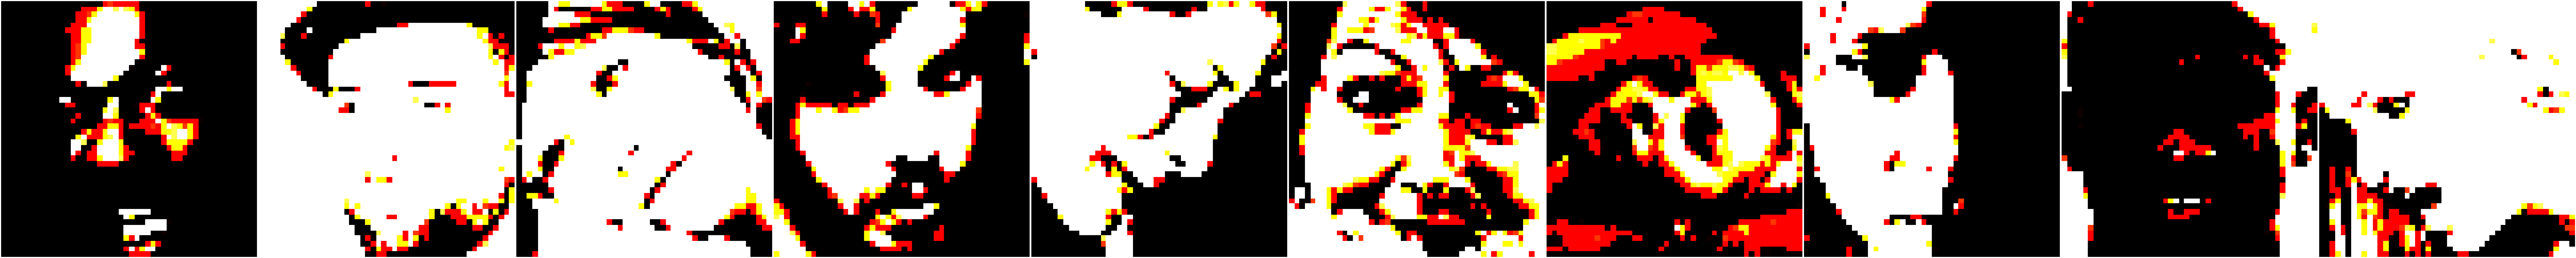

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


In [7]:
imgs, labels = next(train_batches)

# Plotting function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook.
# The classes are represented with the one-hot encoding , for example 'angry' is [1. 0. 0. 0. 0. 0. 0.]

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(224,224))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [8]:
# I download the VGG16 model
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

As we can see VGG16 so very complex with a total of 138,357,544 parameters. It is is much more complex and sophisticated and has many more layers than the model created in v6.

Notice that the last Dense layer of VGG16 has 1000 outputs. These outputs correspond to the 1000 categories in the ImageNet library. We just have 7, but we have to cut more than just the last dense layer, and there is no optimal number or last layers to remove, so we have to experiment. On this v8 I will remove the last 4 layers, on v9 I will try to remove more and experiment.

Before we do that, note that the type of Keras models we've been creating were Sequential, by checking out the type of model vgg16_model is, we see that it is of type Model, which is from the Keras' Functional API.

In [9]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

In [10]:
# I grab the output from the ninth to last layer of the model and store it in this variable x

x = vgg16_model.layers[-9].output

We'll be using this to build a new model. This new model will consist of the original VGG16 up to the ninth from last layer. We won't use the last 8 layers of the original model. We including everything up to and including block4_pool (MaxPooling2D) layer.

In [11]:
# Since I removed the Flatten and fully connected layer form the VGG16 model and I need them, I will crete my own and add them to the initial models we're taking from VGG166, I set only a fully connected layer with 512 nodes
dense = layers.Flatten()(x)
y = layers.Dense(512)(dense)

output = Dense(units=7, activation='softmax')(y)

# Now, we construct the new fine-tuned model, which we're calling model.

model = Model(inputs=vgg16_model.input, outputs=output)

This time we created the model using the Model constructor form Keras Functional API.

In [12]:
for layer in model.layers[:-13]:
    layer.trainable = False

I want to keep some of the initial layers as they are so I set all the layers up to the 13th from the last layer to be non trainable, on v9 I will experiment with another value.

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# Now that the model is built, we compile the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we'll look at accuracy as our performance metric.

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

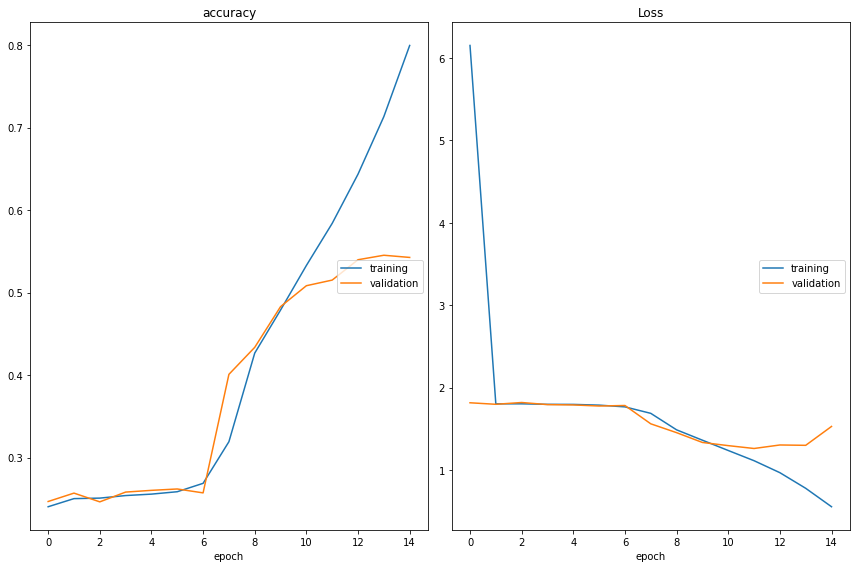

accuracy
	training         	 (min:    0.241, max:    0.799, cur:    0.799)
	validation       	 (min:    0.246, max:    0.545, cur:    0.543)
Loss
	training         	 (min:    0.553, max:    6.154, cur:    0.553)
	validation       	 (min:    1.260, max:    1.818, cur:    1.528)


In [15]:
# I plot the results in real life
callbacks = [PlotLossesKerasTF()]

# Now I will train the model using, I use only 15 epochs since it stops improving after 15 epochs
model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=15,
    callbacks=callbacks
)

This model got about 80% accuracy on the training set, it took time to reach this value. I tough mid training to maybe run it another time with more epochs, maybe 30 epochs, but by the end of the 15 epoch it's clear that the validation accuracy stopped growing, so running more epochs won't probably improve it. Again the model is overfitting and not able to generalize well.

Confusion matrix, without normalization
[[179   3  28  32  60  81  16]
 [ 12  12   2   3   5   9   0]
 [ 62   1 103  24  66  96  57]
 [ 30   0  13 556  61  51  10]
 [ 56   1  26  46 263  99   5]
 [ 65   1  49  35  96 230   7]
 [ 18   0  27  25  16  16 214]]


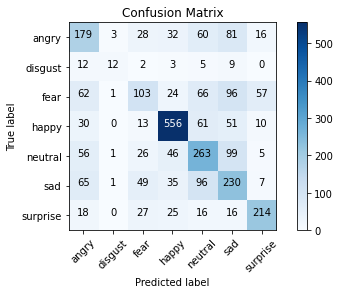

In [16]:
#Plotting Predictions With A Confusion Matrix
# To get a better visualization of these results, we'll plot them in a confusion matrix

test_imgs, test_labels = next(test_batches)
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

This version performed way better than v7, but it's not as good as v8 or v6.

In [17]:
# I will save anyways the model for the archive (I specify the name this time)
model.save("kaggle_model_v9.h5")